In [2]:
import matplotlib.pyplot as plt
import scipy.io as scio

In [3]:
tissue = scio.loadmat('../Data/tissue3_1.mat')
data   = tissue['map_t3']
signal = data[50,50,:]

calibration = scio.loadmat('../Data/cal_14.mat')
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]

In [4]:
# # Functions for Gniadecka et al.'s algorithm
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import numpy as np 
from numpy import gradient

def moving_average(x, w, zero_pad=1):
    if zero_pad == 1:   
        a = np.zeros(int(w/2)-1) 
        z = np.zeros(int(w/2)) 
    else:
        a = np.ones(int(w/2)) * x[0]
        z = np.ones(int(w/2)) * x[-1]
        
    x = np.concatenate((a,x,z))
    return np.convolve(x, np.ones(w), 'valid') / w

def left_boundary(signal, index):
    index = int(np.floor(index))
    if index == 0:
        return index
    
    # Find local maximum to left
    while signal[index-1]>signal[index]:
        index -= 1
        if index == 0:
            return index
    
    # Find last positive value or local minimum to left
    while signal[index]>0.001 and signal[index-1]<signal[index]:
        index -= 1
        if index == 0:
            return index
        
    return index

def right_boundary(signal, index):
    index = int(np.ceil(index))
    if index == 1023:
        return index
    
    # Find local minimum to right
    while signal[index+1]<signal[index]:
        index += 1
        if index == 1023:
            return index
    
    # Find last negative value or local maximum to left
    while signal[index]<-0.001 and signal[index+1]>signal[index]:
        index += 1
        if index == 1023:
            return index
        
    return index

def cum_sum(x):
    count = 0
    for i in range(len(x)):
        count += x[i]
        x[i] = count
    return x

In [5]:
def first_derivative_bl_removal(signal,
                                SG_WIN  = 61,
                                MA_WIN  = 204,
                                MA_WIN2 = 41,
                                MIN_BOUND_LEN = 10):
    """ 
    Input is a raman spectrum:
    - x holds the wavenumbers 
    - signal holds the intensity at each wavenumber
    
    Output:
    - final spectra (without baseline)
    """
    LEN_SIG = len(signal)
    
    # Get baseline contribution to derivative of spectrum
    s_sg = savgol_filter(signal, SG_WIN, 2, mode='nearest')
    s_dif = gradient(s_sg)
    s_sg2 = savgol_filter(s_dif, SG_WIN, 2, mode='nearest')
    s_ma1 = moving_average(s_sg2, MA_WIN)
    s_ma2 = moving_average(s_ma1, MA_WIN)
    s_ma3 = moving_average(s_ma2, MA_WIN)

    # Remove baseline contribution to obtain relevant derivative features (peaks)
    signal_derivative = s_sg2 - s_ma3

    # Find peak locations
    peaks = []
    for i in range(LEN_SIG-1):
        if signal_derivative[i]>0 and signal_derivative[i+1]<0:
            x = [signal_derivative[i], signal_derivative[i+1]]
            y = [i,i+1]
            y_new = np.interp(0, x, y)
            peaks.append(y_new)

    # Find peak boundaries
    left_boundaries = []
    right_boundaries = []

    for i in range(len(peaks)):
        lb = left_boundary(signal_derivative,peaks[i])
        rb = right_boundary(signal_derivative,peaks[i])
        left_boundaries.append(lb)
        right_boundaries.append(rb)
        
    # Remove peaks with small length between boundaries (considered not important)
    count = 0
    for i in range(len(peaks)):
        if right_boundaries[i-count]-left_boundaries[i-count] < MIN_BOUND_LEN:
            left_boundaries.pop(i-count)
            right_boundaries.pop(i-count)
            count += 1
        
    # Interpolate around peaks
    interpolated_peaks = signal.copy()

    for i in range(len(left_boundaries)):
        l = left_boundaries[i]
        r = right_boundaries[i]
        
        peak = s_ma3[l:r]
        no_mean = peak - np.mean(peak)
        integrated = cum_sum(no_mean)

        x = [l,r]
        y = [signal[l], signal[r]]
        f = interp1d(x,y)
        
        count = 0
        while l+count < r:
            interpolated_peaks[l+count] = integrated[count] + f(l+count)
            count += 1
     
    # Smooth       
    baseline = moving_average(interpolated_peaks, MA_WIN2, zero_pad=0)
    baseline = moving_average(baseline, MA_WIN2, zero_pad=0)
    
    # Add constant (make all values positive) - don't see why
    # minimum = np.min(signal-baseline,0)
    
    final_spectrum = signal-baseline
    
    return s_sg, s_sg2, s_ma3, signal_derivative, interpolated_peaks, baseline, final_spectrum

In [6]:
s_smooth, derivative, bl_contrib, peak_contrib, interp_peaks, baseline, final_sig = first_derivative_bl_removal(signal)

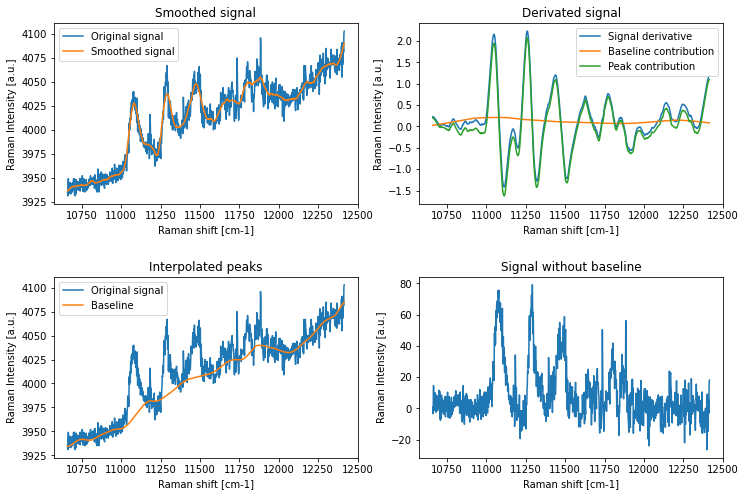

In [7]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(x,signal)
plt.plot(x,s_smooth)
plt.title('Smoothed signal')
plt.legend(['Original signal', 'Smoothed signal'])
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

plt.subplot(2,2,2)
plt.plot(x,derivative)
plt.plot(x,bl_contrib)
plt.plot(x,peak_contrib)
plt.title('Derivated signal')
plt.legend(['Signal derivative', 'Baseline contribution', 'Peak contribution'])
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

plt.subplot(2,2,3)
plt.plot(x,signal)
plt.plot(x,baseline)
plt.title('Interpolated peaks')
plt.legend(['Original signal', 'Baseline'])
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

plt.subplot(2,2,4)
plt.plot(x,final_sig)
plt.title('Signal without baseline')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 0, 'Raman shift [cm-1]')

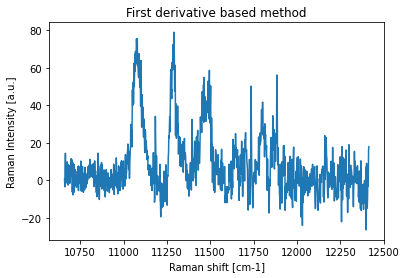

In [12]:
plt.figure(figsize=(6,4))
plt.plot(x,final_sig)
plt.title('First derivative based method')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

How long does it take to run

In [8]:
for i in range(200):
    for j in range(200):
        _, _, _, _, _, _, _ = first_derivative_bl_removal(data[i,j,:])

KeyboardInterrupt: 